# Starbucks Capstone Challenge
---

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets
---

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Problem Statement
---

The Starbucks Capstone Challenge involves building a machine learning model that predicts offer success based on demographic information and offer details provided in the data. The model should be able to accurately predict whether an offer is going to be successfully completed based on customer and offer characteristics.

Additionally, the project aims to answer the following questions:

- Which offer is the most successful?
- Who spends more money, male or female?

The data set simulates customer behavior on the Starbucks rewards mobile app. Starbucks sends out offers to users of the mobile app, which can be an advertisement or an actual offer such as a discount or BOGO. However, not all users receive the same offer, and the challenge is to solve this problem using the available data.

The project involves data cleaning, feature engineering, and building and evaluating the machine learning model. The model's accuracy will be evaluated using appropriate metrics such as precision, recall, and F1-score.

The results of this project can help Starbucks gain insights into customer behavior and optimize their marketing campaigns to increase offer success rates.

In [2]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline


import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,cross_val_score, learning_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import seaborn as sns
sns.set(style = 'darkgrid')

import warnings
warnings.filterwarnings('ignore')

In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Data Exploration
---

#### (a) Portfolio data - offer information


First, let's take a quick look at the different offers in the portfolio.

In [4]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


After examining the portfolio data, I intend to execute the following steps to cleanse the data:

- Assess the categorical columns and decide how to proceed with cleaning them.
- Generate dummy variables for the various offer campaigns represented by different channels.
- Generate dummy variables for the offer types.
- Combine the dummy variable values and drop the original columns.

In [5]:
unique_offers = portfolio['id'].nunique()
print(f"There are {unique_offers} unique offers in the portfolio.")
print("The distribution of these offers among the offer types is as follows:")
print(portfolio.offer_type.value_counts())

There are 10 unique offers in the portfolio.
The distribution of these offers among the offer types is as follows:
bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64


In order to perform analysis, it is necessary to represent the various channels and offer types in a different format. Therefore, it is required to convert the categorical variables into indicator variables.

In [6]:
# Clean channels
channels = pd.get_dummies(portfolio['channels'].apply(pd.Series).stack()).sum(level=0)
portfolio = pd.concat([portfolio, channels], axis=1)
portfolio.drop(['channels'], axis=1, inplace=True)

# Create a new column 'offer' by concatenating offer_type, reward, difficulty, and duration
portfolio['offer_description'] = (portfolio['offer_type'] + "_offer_spend_" + portfolio['difficulty'].astype('str')
                      + "_get_" + portfolio['reward'].astype('str') + "_valid_for_"
                      + portfolio['duration'].astype('str') + "days")

# Clean offer types
offer_types = pd.get_dummies(portfolio['offer_type'])
portfolio = pd.concat([portfolio, offer_types], axis=1)
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)

# Print the updated portfolio
portfolio.head()

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web,offer_description,bogo,discount,informational
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,bogo_offer_spend_10_get_10_valid_for_7days,1,0,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,bogo_offer_spend_10_get_10_valid_for_5days,1,0,0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,informational_offer_spend_0_get_0_valid_for_4days,0,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,bogo_offer_spend_5_get_5_valid_for_7days,1,0,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,discount_offer_spend_20_get_5_valid_for_10days,0,1,0


The next step is to examine the demographic data of the customers, which is stored in the profile dataset. This dataset contains information about the customers' profiles.

In [7]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


To clean the profile data, I will be executing the following steps:

- Check for missing values in the dataset.
- Examine the gender and income columns for any missing data.
- Convert the 'became_member_on' column data to datetime format.
- Calculate the total number of days since a customer became a member and store it in a new column named 'membership_duration'.
- Rename the 'id' column to 'customer_id' and reorder the columns as required.

In [8]:
profile.isnull().sum()*100/len(profile)

gender              12.794118
age                  0.000000
id                   0.000000
became_member_on     0.000000
income              12.794118
dtype: float64

In [9]:
(profile[(profile['gender'].isna()) & (profile['income'].isna())]).head(10)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN
10,None,118,c4863c7985cf408faee930f111475da3,20170824,NaN
11,None,118,148adfcaa27d485b82f323aaaad036bd,20150919,NaN
17,None,118,744d603ef08c4f33af5a61c8c7628d1c,20170801,NaN
23,None,118,2b826eba31074a059d63b0ae8f50b7d5,20170907,NaN


It's worth noting that in cases where gender is marked as "None", the income value is also unknown. Moreover, when both gender and income are unknown, the age value is set to 118 for all rows with NaN values.

Approximately 12.8% of the values in the dataset are missing. As this percentage is relatively small, I have decided to drop these missing values rather than implementing an imputation strategy, especially for the purpose of building a machine learning model.

In [10]:
profile.dropna(inplace=True)

In [11]:
# Calculate membership duration
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
today = datetime.datetime.today().date()
membership_duration = (today - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date).dt.days
profile['membership_duration'] = membership_duration

# Print the first 5 rows of the updated profile DataFrame
profile.head(5)

,gender,age,id,became_member_on,income,membership_duration
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2069
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2136
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,1784
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,1860
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,1950


In [12]:
# Rename 'id' column to 'customer_id'
profile = profile.rename(columns={'id': 'customer_id'})

# Reorder the columns as required
columns_order = ['customer_id', 'gender', 'age', 'income', 'became_member_on', 'membership_duration']
profile = profile[columns_order]

# Reset the index
profile = profile.reset_index(drop=True)

# Print the first few rows of the updated profile DataFrame
profile.head()

,customer_id,gender,age,income,became_member_on,membership_duration
0,0610b486422d4921ae7d2bf64640c50b,F,55,112000.0,2017-07-15,2069
1,78afa995795e4d85b5d9ceeca43f5fef,F,75,100000.0,2017-05-09,2136
2,e2127556f4f64592b11af22de27a7932,M,68,70000.0,2018-04-26,1784
3,389bc3fa690240e798340f5a15918d5c,M,65,53000.0,2018-02-09,1860
4,2eeac8d8feae4a8cad5a6af0499a211d,M,58,51000.0,2017-11-11,1950


To gain insight into the trend of membership growth over time, we can create a line graph that displays the number of new memberships added each year.

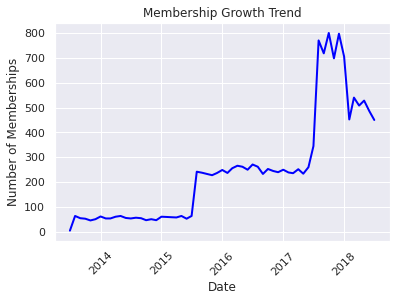

In [13]:
import matplotlib.pyplot as plt

# Group customers by month and year they became members and count the number of customers for each month
membership_counts = profile.groupby(profile['became_member_on'].dt.to_period('M'))['customer_id'].count()

# Plot a line graph to show the trend of membership growth over time
plt.plot(membership_counts.index.to_timestamp(), membership_counts.values, linewidth=2, color='blue')
plt.xlabel('Date')
plt.ylabel('Number of Memberships')
plt.title('Membership Growth Trend')
plt.xticks(rotation=45)
plt.show()



The number of customers has increased every year, as can be seen from the membership growth trend.

To gain insights into the distribution of customer demographics based on their gender, we can create histograms and density plots for their income, age, and membership duration.

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_profile(df, variable):
    '''
    Returns a basic histogram and density plot for demographic variables
    
    INPUT:
    df - the DataFrame including the variable to be plotted
    variable - the variable to be plotted
    
    OUTPUT:
    plt - basic histogram and density plot
    
    '''
    palette = sns.color_palette()
    fig, ax = plt.subplots(figsize=(20, 4), nrows=1, ncols=3, sharex=True, sharey=True)
    
    plt.sca(ax[0])
    sns.distplot(df[df['gender'] == 'F'][variable], bins=10, color=palette[0])
    plt.title('Female\'s {} Distribution'.format(variable))
    plt.xlabel(f'{variable}')
    plt.ylabel('Distribution')

    plt.sca(ax[1])
    sns.distplot(df[df['gender'] == 'M'][variable], bins=10, color=palette[1])
    plt.title('Male\'s {} Distribution'.format(variable))
    plt.xlabel(f'{variable}')

    plt.sca(ax[2])
    sns.distplot(df[df['gender'] == 'O'][variable], bins=10, color=palette[2])
    plt.title('Other\'s {} Distribution'.format(variable))
    plt.xlabel(f'{variable}')
    plt.show()
    
    return plt


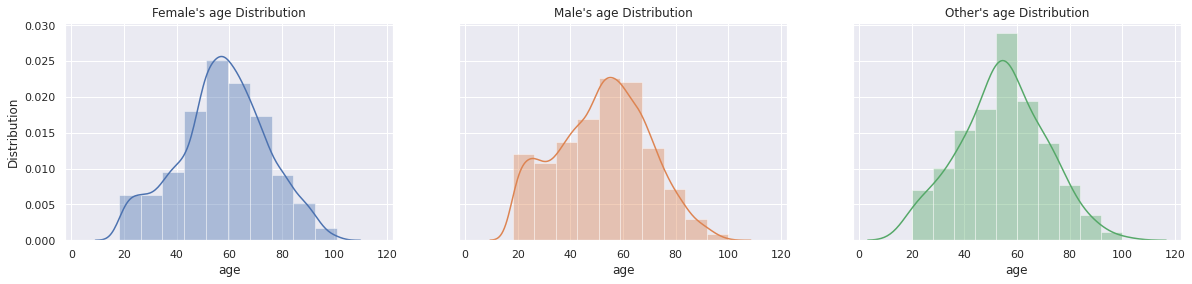

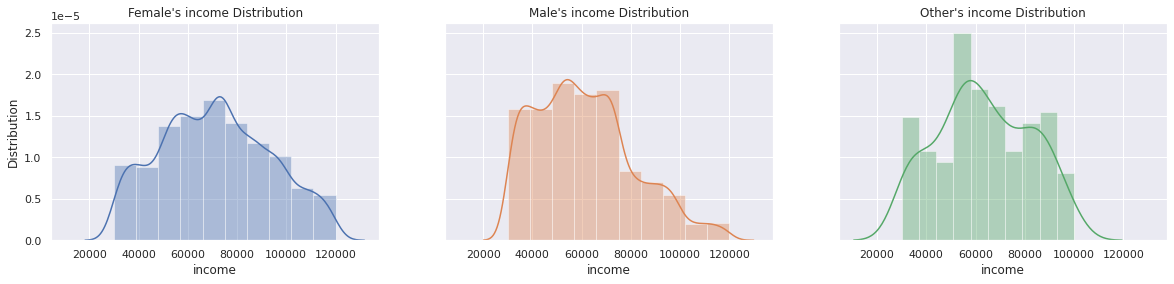

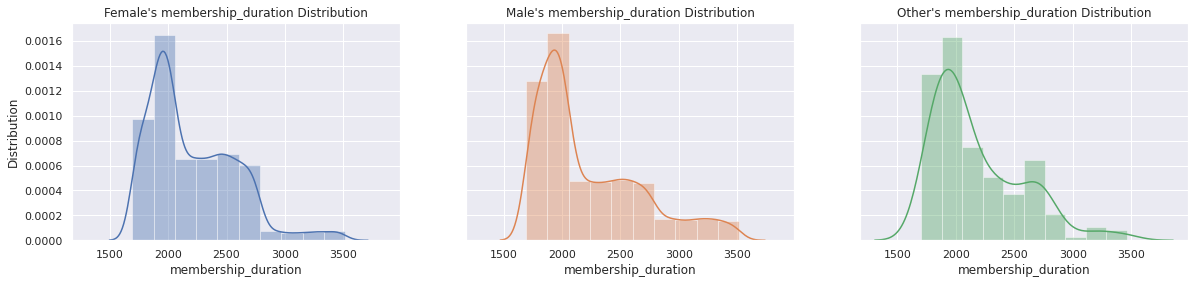

In [15]:
age_plot = plot_profile(profile, 'age')
income_plot = plot_profile(profile, 'income')
membership_duration_plot = plot_profile(profile, 'membership_duration')

Now, we will examine the events related to the offers and transactions in the transcript data.

In [16]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [17]:
unique_events = transcript['event'].unique()
print(f"There are {len(unique_events)} unique event types: {unique_events}")


There are 4 unique event types: ['offer received' 'offer viewed' 'transaction' 'offer completed']


In [18]:
# Count the number of events of each type
event_counts = transcript['event'].value_counts()

# Print the event counts and total number of events
print("Number of events by type:\n", event_counts, "\n")
print("Total number of events:", len(transcript))

# Keep only the rows in transcript that have a valid customer ID in profile
valid_ids = profile['customer_id'].unique()
transcript = transcript[transcript['person'].isin(valid_ids)]
print("Number of events with valid customer IDs:", len(transcript))
transcript.head()

Number of events by type:
 transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64 

Total number of events: 306534
Number of events with valid customer IDs: 272762


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [19]:
# Create a new DataFrame with details about customer ID and amount spent

df_trans = transcript[transcript['event'] == 'transaction']
moneyspent = pd.DataFrame(data=df_trans)
moneyspent = moneyspent.drop(['value', 'event'], axis=1)
moneyspent['amount'] = df_trans['value'].apply(lambda x: list(x.values())[0])
moneyspent = moneyspent.rename(columns={'person': 'customer_id'})
moneyspent = moneyspent.reset_index(drop=True)

# Merge the gender information from the profile DataFrame into moneyspent
moneyspent = pd.merge(moneyspent, profile[['gender', 'customer_id']], how='left', on='customer_id')

# Print the number of rows in moneyspent
print("Number of rows in moneyspent:", len(moneyspent), "\n")

# Display the first 5 rows of moneyspent
moneyspent.head()


Number of rows in moneyspent: 123957 



,customer_id,time,amount,gender
0,02c083884c7d45b39cc68e1314fec56c,0,0.83,F
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,M
2,54890f68699049c2a04d415abc25e717,0,13.23,M
3,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,F
4,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,F


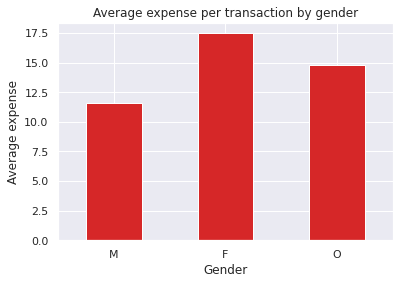

Average expense per transaction by gender:
 gender
F    17.490077
M    11.606600
O    14.798731
Name: amount, dtype: float64


In [20]:
# Group the moneyspent DataFrame by gender and calculate the total number and amount of transactions
gender_groupby = moneyspent.groupby('gender')
gender_transactions = gender_groupby.amount.count()
gender_expense = gender_groupby.amount.sum()

# Calculate the average expense per transaction for each gender and plot the results as a bar chart
avg_expense = gender_expense / gender_transactions
avg_expense.reindex(['M', 'F', 'O']).plot(kind='bar', rot=0, color='tab:red')
plt.title("Average expense per transaction by gender")
plt.xlabel("Gender")
plt.ylabel("Average expense")
plt.show()

# Print the average expense per transaction for each gender
print("Average expense per transaction by gender:\n", avg_expense)

Based on the analysis of the moneyspent DataFrame, it appears that, on average, women tend to spend more money per transaction than men and individuals of other genders.

In [21]:
# Split the 'value' column into separate columns and fill the missing 'offer_id' values
values = transcript['value'].apply(pd.Series)
values.offer_id.fillna(values['offer id'], inplace=True)

# Concatenate the new columns to the original DataFrame
transcript = pd.concat([transcript, values], axis=1)

# Print the first few rows of the updated DataFrame
transcript.head()


,person,event,value,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,3f207df678b143eea3cee63160fa8bed,NaN,3f207df678b143eea3cee63160fa8bed,NaN
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN


In [22]:
# Calculate the number of offers received per customer and save the result in a new DataFrame
num_offers = transcript[transcript['event'] == 'offer received'].groupby('person').count().reset_index()
num_offers.rename(columns={'offer_id': 'num_offers'}, inplace=True)

# Merge the num_offers DataFrame with the original transcript DataFrame
transcript = pd.merge(transcript, num_offers[['person', 'num_offers']], how='left', on='person')

# Convert the 'event' column into indicator variables using one-hot encoding
event_types = pd.get_dummies(transcript['event'])
transcript = pd.concat([transcript, event_types], axis=1)

# Drop unnecessary columns and rename columns as needed
transcript.drop(['offer id', 'value', 'reward'], axis=1, inplace=True)
transcript.rename(columns={'person': 'customer_id'}, inplace=True)

# Print the first few rows of the updated DataFrame
transcript.head()


,customer_id,event,time,amount,offer_id,num_offers,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,4.0,0,1,0,0
1,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,4.0,0,1,0,0
2,389bc3fa690240e798340f5a15918d5c,offer received,0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,6.0,0,1,0,0
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,NaN,3f207df678b143eea3cee63160fa8bed,3.0,0,1,0,0
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,0,1,0,0


To get a better understanding of the event data for each customer and identify relevant factors for analysis, we can filter the data by a single customer ID.

In [23]:
transcript[transcript['customer_id']=='aa4862eba776480b8bb9c68455b8c2e1']

,customer_id,event,time,amount,offer_id,num_offers,offer completed,offer received,offer viewed,transaction
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,0,1,0,0
17761,aa4862eba776480b8bb9c68455b8c2e1,offer viewed,18,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,0,0,1,0
47388,aa4862eba776480b8bb9c68455b8c2e1,offer received,168,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,5.0,0,1,0,0
58447,aa4862eba776480b8bb9c68455b8c2e1,offer viewed,168,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,5.0,0,0,1,0
74088,aa4862eba776480b8bb9c68455b8c2e1,transaction,210,12.33,NaN,5.0,0,0,0,1
74089,aa4862eba776480b8bb9c68455b8c2e1,offer completed,210,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,5.0,1,0,0,0
98720,aa4862eba776480b8bb9c68455b8c2e1,offer received,336,NaN,5a8bc65990b245e5a138643cd4eb9837,5.0,0,1,0,0
109797,aa4862eba776480b8bb9c68455b8c2e1,offer viewed,336,NaN,5a8bc65990b245e5a138643cd4eb9837,5.0,0,0,1,0
133964,aa4862eba776480b8bb9c68455b8c2e1,offer received,408,NaN,ae264e3637204a6fb9bb56bc8210ddfd,5.0,0,1,0,0
154828,aa4862eba776480b8bb9c68455b8c2e1,transaction,426,15.95,NaN,5.0,0,0,0,1


To perform analysis on both the transcript and portfolio data, we need to merge the two data sets based on their common offer ID column, creating one combined data set for analysis.

In [24]:
# Merge the 'transcript' and 'portfolio' DataFrames based on 'offer_id'
merged_data = pd.merge(transcript, portfolio, how='left', on='offer_id')

# Count the number of customers for each combination of 'offer_type' and 'event' using groupby()
customer_count = merged_data.groupby(['offer_type', 'event']).customer_id.count()

# Print the resulting customer count for each combination of 'offer_type' and 'event'
print(customer_count)

# Print the first few rows of the merged DataFrame
merged_data.head()


offer_type     event          
bogo           offer completed    15258
               offer received     26537
               offer viewed       22039
discount       offer completed    17186
               offer received     26664
               offer viewed       18461
informational  offer received     13300
               offer viewed        9360
Name: customer_id, dtype: int64


,customer_id,event,time,amount,offer_id,num_offers,offer completed,offer received,offer viewed,transaction,...,duration,offer_type,email,mobile,social,web,offer_description,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,4.0,0,1,0,0,...,7.0,bogo,1.0,1.0,0.0,1.0,bogo_offer_spend_5_get_5_valid_for_7days,1.0,0.0,0.0
1,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,4.0,0,1,0,0,...,7.0,discount,1.0,1.0,0.0,1.0,discount_offer_spend_10_get_2_valid_for_7days,0.0,1.0,0.0
2,389bc3fa690240e798340f5a15918d5c,offer received,0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,6.0,0,1,0,0,...,5.0,bogo,1.0,1.0,1.0,1.0,bogo_offer_spend_5_get_5_valid_for_5days,1.0,0.0,0.0
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,NaN,3f207df678b143eea3cee63160fa8bed,3.0,0,1,0,0,...,4.0,informational,1.0,1.0,0.0,1.0,informational_offer_spend_0_get_0_valid_for_4days,0.0,0.0,1.0
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,0,1,0,0,...,10.0,discount,1.0,0.0,0.0,1.0,discount_offer_spend_20_get_5_valid_for_10days,0.0,1.0,0.0


To explore the relationship between offer types and events in the combined data, we can create a visualization

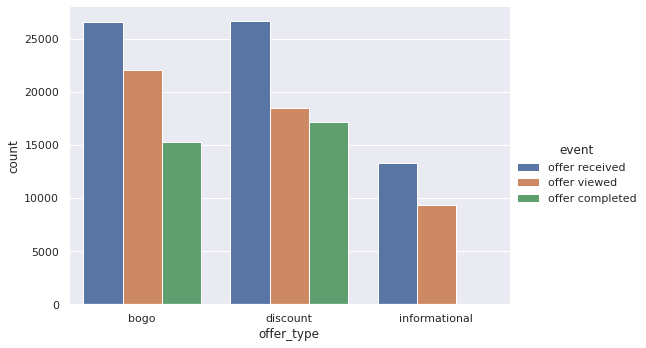

In [25]:
events_by_offer_type = sns.catplot(data=merged_data[merged_data['event'] != 'transaction'], 
                                   x='offer_type', hue='event', kind='count', aspect=1.5)

### Data Preparation
---

The data we have currently is not sufficient for model training. Basic cleaning has been done, but the data needs to be further prepared for modeling.

To prepare the data, a separate column needs to be added to identify successful cases. For BOGO and discount offers, the possible event paths are:

- Successful offer: offer received → offer viewed → transaction(s) → offer completed
- Ineffective offer: offer received → offer viewed
- Unviewed offer: offer received
- Unviewed success: offer received → transaction(s) → offer completed

A successful offer means that the customer viewed the offer and completed the offer resulting in a transaction. An ineffective offer means that the customer viewed the offer but did not complete it, and an unviewed offer means that the customer did not view the offer at all.

However, it's important to distinguish between successful offers and unviewed success cases, where the customer completed the offer without viewing it. It is essential to separate these to target the right customers effectively.

Ideally, Starbucks should target customer groups that follow event path 1 and avoid targeting those that are likely to follow paths 2, 3, and 4, as they are unlikely to make transactions or will make transactions regardless of the offer.

In [26]:
def prepare_offer_completion(data):
    '''
    Cleans dataframe for further analysis based on offer completion
    
    INPUT:
    data - The dataframe to be cleaned
    
    OUTPUT:
    cleaned - The cleaned dataframe
    
    ''' 
    pd.options.mode.chained_assignment = None
    
    # Identify success cases in 'offer completed' rows
    offers_completed = data[['customer_id', 'event', 'time', 'offer_id', 'num_offers']].sort_values(['customer_id','time'])
    offers_completed = offers_completed[(offers_completed['event']=='offer viewed') | (offers_completed['event']=='offer completed')]
    
    # Use shift() to identify unviewed successes
    offers_completed['previous_offer_id'] = offers_completed.groupby(['customer_id', 'offer_id'])['offer_id'].shift()
    offers_completed['success'] = np.where((offers_completed['event'] == 'offer completed') & (offers_completed['previous_offer_id'] == offers_completed['offer_id']), 1, 0)
    offers_completed['unviewed_success'] = np.where((offers_completed['event'] == 'offer completed') & (offers_completed['previous_offer_id'].isna()), 1, 0)
    offers_completed.drop(['previous_offer_id'], axis=1, inplace=True)
    
    # Re-include 'offer received' rows
    received_offers = data[['customer_id', 'event', 'time', 'offer_id', 'num_offers']][data['event']=='offer received'].sort_values(['customer_id','time'])
    combined = received_offers.append(offers_completed).sort_values(['customer_id','time'])
    combined = combined.sort_values(['customer_id','time'])
    
    # Transmit information from 'offer completed' to corresponding 'offer received' rows
    successes = combined[(combined['event']=='offer received') | (combined['event']=='offer completed')]
    successes['success'] = successes.groupby(['customer_id', 'offer_id'])['success'].bfill()
    successes['unviewed_success'] = successes.groupby(['customer_id', 'offer_id'])['unviewed_success'].bfill()
    result = successes[successes['event']=='offer received']
    
    # Classify remaining offers as failures and fill missing values
    result['failure'] = np.where((result['success'].isna()) & (result['unviewed_success'].isna()), 1, 0)
    result['success'] = np.where(result['success'].isna(), 0, result['success'])
    result['success'] = result['success'].astype('int')
    result['unviewed_success'] = np.where(result['unviewed_success'].isna(), 0, result['unviewed_success'])
    result['unviewed_success'] = result['unviewed_success'].astype('int')
    
    # Build categorical outcome column and add to result
    result['outcome'] = np.where(result['success'] == 1, 'success', np.where(result['unviewed_success'] == 1, 'unviewed success', 'failure'))
    outcome_map = {'failure': 0, 'unviewed success': 1, 'success': 2}
    result['outcome_factor'] = result['outcome'].map(outcome_map)
    
    # Add customer and offer information
    cleaned = pd.merge(result, portfolio, how='left', on='offer_id')
    cleaned = pd.merge(cleaned, profile, how='left', on='customer_id')
    cleaned.drop(['event', 'became_member_on'], axis=1, inplace=True)
    
    pd.options.mode.chained_assignment = "warn"
    
    return cleaned

In [27]:
# create separate dataframes for BOGO and discount offers
bogo = merged_data[merged_data['offer_type']=='bogo']
discount = merged_data[merged_data['offer_type']=='discount']

# append the two dataframes together
bogo_discount_notcleaned = bogo.append(discount)

# clean the dataframes using prepare_offer_completion() function
bogo_cleaned = prepare_offer_completion(bogo)
discount_cleaned = prepare_offer_completion(discount)

# append the cleaned dataframes together
bogo_discount = bogo_cleaned.append(discount_cleaned)

# print the first 5 rows of the cleaned and combined BOGO and discount dataframes
bogo_discount.head()

,customer_id,time,offer_id,num_offers,success,unviewed_success,failure,outcome,outcome_factor,reward,...,social,web,offer_description,bogo,discount,informational,gender,age,income,membership_duration
0,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,5.0,0,1,0,unviewed success,1,5,...,1,1,bogo_offer_spend_5_get_5_valid_for_5days,1,0,0,M,33,72000.0,2154
1,0011e0d4e6b944f998e987f904e8c1e5,504,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,1,0,0,success,2,5,...,0,1,bogo_offer_spend_5_get_5_valid_for_7days,1,0,0,O,40,57000.0,1891
2,0020c2b971eb4e9188eac86d93036a77,168,ae264e3637204a6fb9bb56bc8210ddfd,5.0,0,0,1,failure,0,10,...,1,0,bogo_offer_spend_10_get_10_valid_for_7days,1,0,0,F,59,90000.0,2567
3,0020c2b971eb4e9188eac86d93036a77,408,4d5c57ea9a6940dd891ad53e9dbe8da0,5.0,1,0,0,success,2,10,...,1,1,bogo_offer_spend_10_get_10_valid_for_5days,1,0,0,F,59,90000.0,2567
4,0020ccbbb6d84e358d3414a3ff76cffd,336,f19421c1d4aa40978ebb69ca19b0e20d,4.0,1,0,0,success,2,5,...,1,1,bogo_offer_spend_5_get_5_valid_for_5days,1,0,0,F,24,60000.0,2315


In [28]:
def prepare_offer_info_tranx(df):
    '''
    Cleans dataframe for further analysis based on transactions within the validity period
    
    INPUT:
    df - the dataframe to be cleaned
    
    OUTPUT:
    cleaned - the cleaned dataframe
    
    '''
    cleaned = df.sort_values(['customer_id','time'])

    # Calculate remaining time for offers
    cleaned['duration_hrs'] = cleaned.duration * 24

    # If offer received then add duration_hrs to time, else put nan
    cleaned['end_time'] = np.where(cleaned['event'] == 'offer received', cleaned['time'] + cleaned['duration_hrs'], np.nan)
    cleaned['end_time'] = cleaned.groupby('customer_id')['end_time'].ffill()
    cleaned['remaining'] = cleaned['end_time'] - cleaned.time

    cleaned['offer_description'] = np.where((cleaned['event'] == 'transaction') & (cleaned['remaining'] >= 0), cleaned['offer_description'].ffill(), cleaned.offer_description)

    # Get rid of all transactions that do not belong to an offer
    cleaned = cleaned[-cleaned['offer_description'].isna()]

    # Calculate transaction sum during offer validity period using transactions and offer viewed
    temp = cleaned[(cleaned['event'] == 'offer viewed') | (cleaned['event'] == 'transaction')]
    temp2 = pd.DataFrame(temp.groupby(['customer_id', 'offer_description'])['amount'].sum())
    temp2.rename(columns={'amount': 'sum'}, inplace=True)
    temp3 = pd.merge(temp, temp2, how='left', on=['customer_id', 'offer_description'])
    temp3['amount'] = np.where(temp3['event'] == 'offer viewed', temp3['sum'], temp3['amount'])
    cleaned = cleaned[cleaned['event'] == 'offer received'].append(temp3).sort_values(['customer_id', 'time'])
    cleaned = cleaned.drop(columns=['duration_hrs', 'end_time', 'remaining', 'sum'])

    # Transfer transaction sum to 'offer received' rows
    cleaned = cleaned[-(cleaned['event'] == 'transaction')]
    cleaned['amount'] = cleaned.groupby(['customer_id', 'offer_description'])['amount'].shift(-1)
    cleaned = cleaned[cleaned['event'] == 'offer received']
    cleaned['amount'] = cleaned['amount'].fillna(0)

    # Add success indicator
    cleaned['success'] = np.where(cleaned['amount'] > 0, 1, 0)
    cleaned['unviewed_success'] = -99
    cleaned['failure'] = -99
    cleaned['outcome'] = -99
    cleaned['outcome_factor'] = -99

    # Add customer information
    cleaned = pd.merge(cleaned, profile, how='left', on='customer_id')
    cleaned.drop(['event', 'became_member_on'], axis=1, inplace=True)

    return cleaned


In [29]:
# creating a new dataframe for 'informational' offers and transactions
info_df = merged_data[(merged_data['offer_type']=='informational') |(merged_data['event']=='transaction')]

# cleaning the 'informational' dataframe by calling the function 'prepare_offer_info_tranx'
info_cleaned = prepare_offer_info_tranx(info_df)

# displaying the first 5 rows of the cleaned dataframe
info_cleaned.head(5)

,customer_id,time,amount,offer_id,num_offers,offer completed,offer received,offer viewed,transaction,reward,...,informational,success,unviewed_success,failure,outcome,outcome_factor,gender,age,income,membership_duration
0,0009655768c64bdeb2e877511632db8f,168,22.16,5a8bc65990b245e5a138643cd4eb9837,5.0,0,1,0,0,0.0,...,1.0,1,-99,-99,-99,-99,M,33,72000.0,2154
1,0009655768c64bdeb2e877511632db8f,336,8.57,3f207df678b143eea3cee63160fa8bed,5.0,0,1,0,0,0.0,...,1.0,1,-99,-99,-99,-99,M,33,72000.0,2154
2,0011e0d4e6b944f998e987f904e8c1e5,0,0.00,3f207df678b143eea3cee63160fa8bed,5.0,0,1,0,0,0.0,...,1.0,0,-99,-99,-99,-99,O,40,57000.0,1891
3,0011e0d4e6b944f998e987f904e8c1e5,336,0.00,5a8bc65990b245e5a138643cd4eb9837,5.0,0,1,0,0,0.0,...,1.0,0,-99,-99,-99,-99,O,40,57000.0,1891
4,0020c2b971eb4e9188eac86d93036a77,504,51.10,5a8bc65990b245e5a138643cd4eb9837,5.0,0,1,0,0,0.0,...,1.0,1,-99,-99,-99,-99,F,59,90000.0,2567


Now that the data for all offer types has been cleaned and enriched by a binary measure for offer success, it can be merged into one dataset. This dataset will be used to build the classification model.

In [30]:
# create a new dataframe for testing by dropping the 'amount' column
info_test = info_cleaned.drop(columns=['amount'])

# combine the cleaned BOGO and discount offers with the cleaned info_test dataframe
df_final = bogo_discount.append(info_test)

# display the first few rows of the combined dataframe
df_final.head()

,customer_id,time,offer_id,num_offers,success,unviewed_success,failure,outcome,outcome_factor,reward,...,discount,informational,gender,age,income,membership_duration,offer completed,offer received,offer viewed,transaction
0,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,5.0,0,1,0,unviewed success,1,5.0,...,0.0,0.0,M,33,72000.0,2154,NaN,NaN,NaN,NaN
1,0011e0d4e6b944f998e987f904e8c1e5,504,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,1,0,0,success,2,5.0,...,0.0,0.0,O,40,57000.0,1891,NaN,NaN,NaN,NaN
2,0020c2b971eb4e9188eac86d93036a77,168,ae264e3637204a6fb9bb56bc8210ddfd,5.0,0,0,1,failure,0,10.0,...,0.0,0.0,F,59,90000.0,2567,NaN,NaN,NaN,NaN
3,0020c2b971eb4e9188eac86d93036a77,408,4d5c57ea9a6940dd891ad53e9dbe8da0,5.0,1,0,0,success,2,10.0,...,0.0,0.0,F,59,90000.0,2567,NaN,NaN,NaN,NaN
4,0020ccbbb6d84e358d3414a3ff76cffd,336,f19421c1d4aa40978ebb69ca19b0e20d,4.0,1,0,0,success,2,5.0,...,0.0,0.0,F,24,60000.0,2315,NaN,NaN,NaN,NaN


In [31]:
# Replace missing values with 0 in df_final
df_final = df_final.fillna(0)

# Display information about df_final
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66501 entries, 0 to 13299
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customer_id          66501 non-null  object 
 1   time                 66501 non-null  int64  
 2   offer_id             66501 non-null  object 
 3   num_offers           66501 non-null  float64
 4   success              66501 non-null  int64  
 5   unviewed_success     66501 non-null  int64  
 6   failure              66501 non-null  int64  
 7   outcome              66501 non-null  object 
 8   outcome_factor       66501 non-null  int64  
 9   reward               66501 non-null  float64
 10  difficulty           66501 non-null  float64
 11  duration             66501 non-null  float64
 12  offer_type           66501 non-null  object 
 13  email                66501 non-null  float64
 14  mobile               66501 non-null  float64
 15  social               66501 non-null 

In [32]:
# Print total counts of different events for BOGO offer
print('The total counts of different events for BOGO offer is:')
print(bogo.event.value_counts())

# Print total counts of different events for discount offer
print('\n\nThe total counts of different events for discount offer is:')
print(discount.event.value_counts())

The total counts of different events for BOGO offer is:
offer received     26537
offer viewed       22039
offer completed    15258
Name: event, dtype: int64


The total counts of different events for discount offer is:
offer received     26664
offer viewed       18461
offer completed    17186
Name: event, dtype: int64


Let's create a graph to analyze the total count of BOGO offers versus discount offers.

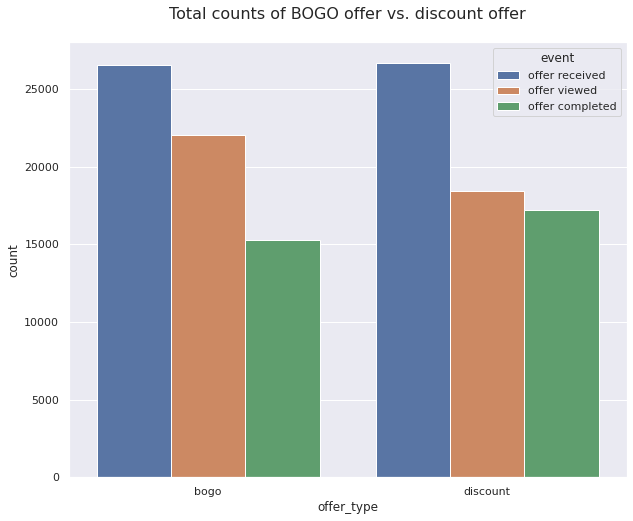

In [33]:
# plot a countplot to compare the total counts of BOGO and discount offers
fig, ax = plt.subplots(figsize=(10,8))

# use seaborn countplot to visualize the data
sns.countplot(x="offer_type", hue="event", data=bogo_discount_notcleaned)

# add title to the plot
plt.title("Total counts of BOGO offer vs. discount offer\n", fontsize=16);

In [34]:
def event_counts(df):
    """
    Returns the counts of each individual event
    
    INPUT:
    df - dataframe
    
    OUTPUT:
    counts - counts of each individual event
    """
    events = df['event'].unique()
    counts = []
    for event in events:
        count = len(df[df['event'] == event])
        yield count

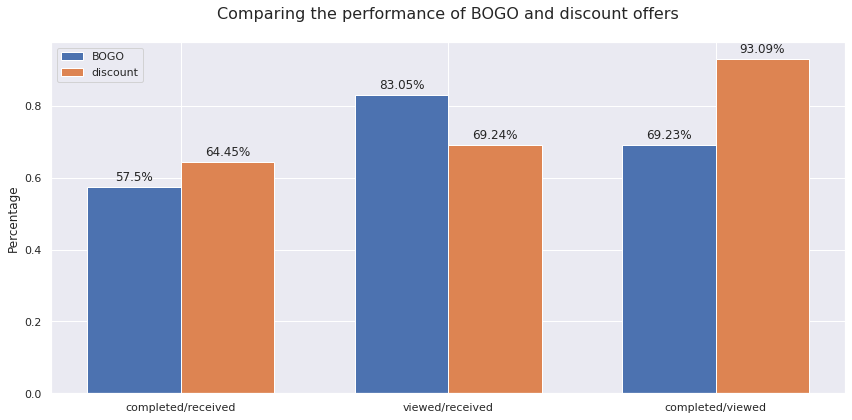

In [35]:
# Get event counts for BOGO offer
bogo_received, bogo_viewed, bogo_completed = event_counts(bogo)

# Get event counts for discount offer
discount_received, discount_viewed, discount_completed = event_counts(discount)

# Create lists of performance percentages for BOGO and discount offers
labels = ['completed/received', 'viewed/received', 'completed/viewed']
bogo_performance = [bogo_completed/bogo_received, bogo_viewed/bogo_received, bogo_completed/bogo_viewed]
discount_performance = [discount_completed/discount_received, discount_viewed/discount_received, discount_completed/discount_viewed]

# Set up plot
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots(figsize=(12,6))

# Create bars for BOGO and discount offers
rects1 = ax.bar(x - width/2, bogo_performance, width, label='BOGO')
rects2 = ax.bar(x + width/2, discount_performance, width, label='discount')

# Add labels and legend
ax.set_ylabel('Percentage')
ax.set_title('Comparing the performance of BOGO and discount offers\n', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add labels to the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}%'.format(round(height*100, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

# Call autolabel function on each bar
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

The discount offer appears to be more successful compared to BOGO because it has not only slightly higher absolute numbers of 'offer completed' but also a higher overall completed/received rate of around 7%. On the other hand, BOGO offers have a better chance of being viewed by customers. However, it's easier to turn offer received to offer completed with a discount offer than a BOGO offer.

Additionally, we can examine offers that follow the successful offer path of 'offer received → offer viewed → transaction(s) → offer completed'.

In [36]:
pd.DataFrame(df_final.groupby(['offer_description'])['success'].mean()).reset_index().sort_values('success', ascending=False)

,offer_description,success
4,discount_offer_spend_10_get_2_valid_for_10days,0.691371
7,discount_offer_spend_7_get_3_valid_for_7days,0.665214
8,informational_offer_spend_0_get_0_valid_for_3days,0.640373
2,bogo_offer_spend_5_get_5_valid_for_5days,0.563108
0,bogo_offer_spend_10_get_10_valid_for_5days,0.457455
1,bogo_offer_spend_10_get_10_valid_for_7days,0.435583
9,informational_offer_spend_0_get_0_valid_for_4days,0.382605
3,bogo_offer_spend_5_get_5_valid_for_7days,0.374869
5,discount_offer_spend_10_get_2_valid_for_7days,0.367667
6,discount_offer_spend_20_get_5_valid_for_10days,0.243533


The results indicate that the discount offers have a higher success rate compared to the BOGO offers.

### Model Building & Evaluation
---

The next step is to develop a machine learning model that can predict offer success by utilizing offer and customer characteristics. The metrics that will be used to evaluate the model's performance are accuracy_score and roc_auc_score.

In [37]:
# drop rows with missing values
df_final = df_final.dropna(how='any', axis=0)

# create dummy variables for gender
gender = pd.get_dummies(df_final.gender)
df_final = pd.concat([df_final, gender], axis=1)

# define features (X) and target (y) variables
X = df_final.drop(columns=['customer_id', 'offer_id', 'time', 'offer_type', 'gender','offer_description','success', 'unviewed_success', 'failure', 'outcome', 'outcome_factor','offer completed','offer received','offer viewed','transaction'])
y = df_final['success']

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (53200, 17)
X_test shape: (13301, 17)
y_train shape: (53200,)
y_test shape: (13301,)


In [74]:
# create a dictionary of models with their names as keys and the model object as value
models = {'Random Forest': RandomForestClassifier(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'AdaBoost': AdaBoostClassifier(),
          'Logistic Regression': LogisticRegression()}

# create empty lists to store the results for each model
model_names = []
train_accuracy = []
train_roc_auc = []
train_f1 = []
test_accuracy = []
test_roc_auc = []
test_f1 = []

# iterate over the models dictionary
for name, model in models.items():
    # create a pipeline with StandardScaler and the classifier
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    # fit the pipeline on the training set
    pipeline.fit(X_train, y_train)
    
    # predict the target variable for the training and test sets
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    # calculate accuracy, ROC AUC score, and F1 score for the training set
    train_accuracy.append(accuracy_score(y_train, y_train_pred))
    train_roc_auc.append(roc_auc_score(y_train, y_train_pred))
    train_f1.append(f1_score(y_train, y_train_pred))
    
    # calculate accuracy, ROC AUC score, and F1 score for the test set
    test_accuracy.append(accuracy_score(y_test, y_test_pred))
    test_roc_auc.append(roc_auc_score(y_test, y_test_pred))
    test_f1.append(f1_score(y_test, y_test_pred))
    
    # append the model name to the model_names list
    model_names.append(name)
    
# create a DataFrame to store the results
results = pd.DataFrame({'Model': model_names,
                        'Train Accuracy': train_accuracy,
                        'Train ROC AUC': train_roc_auc,
                        'Train F1': train_f1,
                        'Test Accuracy': test_accuracy,
                        'Test ROC AUC': test_roc_auc,
                        'Test F1': test_f1})


In [75]:
# sort the DataFrame by Test F1 score in descending order
results = results.sort_values('Test Accuracy', ascending=False).reset_index(drop=True)

# display the results DataFrame
results

,Model,Train Accuracy,Train ROC AUC,Train F1,Test Accuracy,Test ROC AUC,Test F1
0,Random Forest,0.975263,0.975194,0.974395,0.705511,0.705097,0.691793
1,Gradient Boosting,0.687820,0.687148,0.673790,0.688369,0.687199,0.669115
2,AdaBoost,0.666898,0.666498,0.655173,0.673634,0.672931,0.657028
3,Logistic Regression,0.640489,0.639611,0.622449,0.644237,0.642780,0.620955


In [37]:
# Create a pipeline with StandardScaler and the classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', None)
])

# Set the parameter grid for each model
param_grid = [
    # Random Forest
    {
        'model': [RandomForestClassifier()],
        'model__n_estimators': [50, 100, 500],
        'model__max_depth': [5, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__bootstrap': [True, False],
        'model__random_state': [42]
    },
    # Gradient Boosting
    {
        'model': [GradientBoostingClassifier()],
        'model__n_estimators': [50, 100, 500],
        'model__learning_rate': [0.1, 0.5, 1],
        'model__max_depth': [3, 5, 10],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__random_state': [42]
    },
    # AdaBoost
    {
        'model': [AdaBoostClassifier()],
        'model__n_estimators': [50, 100, 500],
        'model__learning_rate': [0.1, 0.5, 1],
        'model__algorithm': ['SAMME.R','SAMME'],
        'model__random_state': [42]
    },
    # Logistic Regression
    {
        'model': [LogisticRegression()],
        'model__C': [0.1, 1, 10],
        'model__penalty': ['l1', 'l2'],
        'model__solver': ['liblinear'],
        'model__random_state': [42]
    }
]

In [39]:
# create the GridSearchCV object with verbose=True
grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=1)

# fit method 
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 429 candidates, totalling 1287 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', None)]),
             param_grid=[{'model': [RandomForestClassifier()],
                          'model__bootstrap': [True, False],
                          'model__max_depth': [5, 10, 20],
                          'model__min_samples_leaf': [1, 2, 4],
                          'model__min_samples_split': [2, 5, 10],
                          'model__n_estimators': [50, 100, 500],
                          'model__random_state': [42]},
                         {'model': [GradientB...
                          'model__random_state': [42]},
                         {'model': [AdaBoostClassifier()],
                          'model__algorithm': ['SAMME.R', 'SAMME'],
                          'model__learning_rate': [0.1, 0.5, 1],
                          'model__n_estimators': [50, 100, 500],
                          'model__random_state': [42]},
  

In [ ]:
# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best model and its parameters
print("Best model: ", best_model)
print("Best parameters: ", best_params)


Best model:  Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 GradientBoostingClassifier(max_depth=10, min_samples_leaf=2,
                                            min_samples_split=10,
                                            random_state=42))])
Best parameters:  {'model': GradientBoostingClassifier(max_depth=10, min_samples_leaf=2,
                           min_samples_split=10, random_state=42), 'model__learning_rate': 0.1, 'model__max_depth': 10, 'model__min_samples_leaf': 2, 'model__min_samples_split': 10, 'model__n_estimators': 100, 'model__random_state': 42}


In [ ]:
# Test the best model with the test dataset and get the accuracy and roc_auc score
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Accuracy: ", acc)
print("ROC AUC score: ", roc_auc)

Accuracy:  0.7106232614089166
ROC AUC score:  0.7098017318790754


In [48]:
# Display classification report using target names for y_test and model_predictions
print(classification_report(y_test, y_pred, target_names=['failure', 'success']))

              precision    recall  f1-score   support

     failure       0.72      0.73      0.73      6995
     success       0.70      0.69      0.69      6306

    accuracy                           0.71     13301
   macro avg       0.71      0.71      0.71     13301
weighted avg       0.71      0.71      0.71     13301



In [76]:
# training best model after gridsearch execution

grid_best_model = GradientBoostingClassifier(max_depth=10, min_samples_leaf=2,min_samples_split=10, random_state=42)
grid_best_model.fit(X_train, y_train)    

GradientBoostingClassifier(max_depth=10, min_samples_leaf=2,
                           min_samples_split=10, random_state=42)

In [77]:
# calculate the metrics on train data
train_pred = grid_best_model.predict(X_train)
train_acc = accuracy_score(y_train, train_pred)
train_auc = roc_auc_score(y_train, train_pred)
train_f1 = f1_score(y_train, train_pred)
    
# calculate the metrics on test data
test_pred = grid_best_model.predict(X_test)
test_acc = accuracy_score(y_test, test_pred)
test_auc = roc_auc_score(y_test, test_pred)
test_f1 = f1_score(y_test, test_pred)
    
# append the results to the dataframe
results = results.append({
        'Model': 'Gradient Boosting(Tunned)',
        'Train Accuracy': train_acc,
        'Train ROC AUC': train_auc,
        'Test Accuracy': test_acc,
        'Test ROC AUC': test_auc,
        'Train F1': train_f1,
        'Test F1': test_f1
    }, ignore_index=True)

In [78]:
# sort the DataFrame by Test F1 score in descending order
results = results.sort_values('Test Accuracy', ascending=False).reset_index(drop=True)

# display the results DataFrame
results

,Model,Train Accuracy,Train ROC AUC,Train F1,Test Accuracy,Test ROC AUC,Test F1
0,Gradient Boosting(Tunned),0.841541,0.841497,0.836843,0.710247,0.709405,0.694030
1,Random Forest,0.975263,0.975194,0.974395,0.705511,0.705097,0.691793
2,Gradient Boosting,0.687820,0.687148,0.673790,0.688369,0.687199,0.669115
3,AdaBoost,0.666898,0.666498,0.655173,0.673634,0.672931,0.657028
4,Logistic Regression,0.640489,0.639611,0.622449,0.644237,0.642780,0.620955


In [67]:
feat_imp = pd.DataFrame(grid_best_model.feature_importances_, index=X.columns, columns=['importance']).sort_values('importance', ascending=False).reset_index()
feat_imp.rename(columns={'index':'feature'},inplace=True)

feat_imp.head()

,feature,importance
0,membership_duration,0.350805
1,income,0.183660
2,age,0.157774
3,social,0.109451
4,reward,0.050270


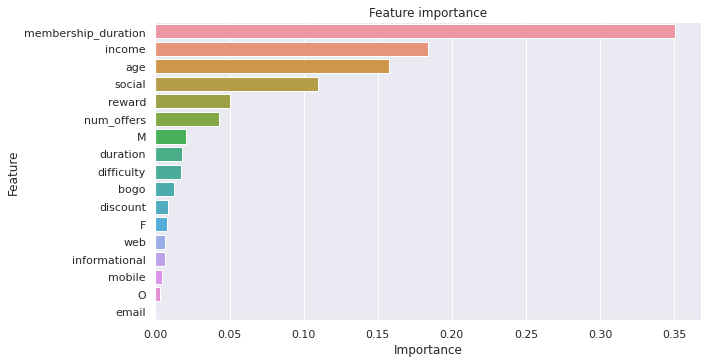

In [68]:
# Create a bar plot using Seaborn's catplot function

plot = sns.catplot(data=feat_imp.reset_index(), y='feature', x='importance', kind='bar', aspect=2)

# Set the plot title
plot.set(title='Feature importance')

# Set the y-axis label
plot.set(ylabel='Feature')

# Set the x-axis label
plot.set(xlabel='Importance')

# Show the plot
plt.show()


According to my model, the factors that have the highest impact are membership duration, income and age.

In [69]:
# Calculate the mean income for each success category in the df_final dataframe
income_by_success = df_final.groupby('success')['income'].mean()

# Display the results
income_by_success


success
0    63151.442168
1    67759.699117
Name: income, dtype: float64

Offers are more likely to be successful for members with higher incomes.

In [70]:
# Calculate the mean success rate for each channel in the df_final dataframe

df_final.groupby(['social'])['success'].mean()

social
0.0    0.341923
1.0    0.575599
Name: success, dtype: float64

In [71]:
df_final.groupby(['web'])['success'].mean()

web
0.0    0.537671
1.0    0.467776
Name: success, dtype: float64

In [72]:
df_final.groupby(['mobile'])['success'].mean()

mobile
0.0    0.243533
1.0    0.508591
Name: success, dtype: float64

In [73]:
df_final.groupby(['email'])['success'].mean()

email
1.0    0.481782
Name: success, dtype: float64

Offers are more likely to be successful when they are sent out via the 'social' channel. 

### Conclusion
---

The goal of this project was to build a machine learning model that predicts offer success based on demographic and offer details provided in the data. We built a simple classification model using several algorithms such as random forest, gradient boosting, AdaBoost, and logistic regression, and found that the Gradient Boosting classifier had the highest accuracy for this task.

The final model has an accuracy of 71%, which is a good number for business purposes, although there is still room for improvement. 

We identified that membership duration, income, and age were the most relevant factors for offer success based on the model.

We also answered the following questions in the process of building the model:

- Which offer is the most successful?

We found that the discount offer was more successful than the BOGO offer because it had a higher overall completed/received rate and a slightly higher absolute number of completed offers. However, the BOGO offer had a greater chance of being viewed or seen by customers.

- Who spends more money, male or female?

Based on the graph data, we found that female customers spend more money than male customers. This insight can help Starbucks in targeting their customers more effectively.

Future scope of this project includes exploring better modeling techniques and algorithms to improve the model's performance. We also plan to use an imputation strategy for missing values to see if the model can be improved in this way. Overall, the results of this project can help Starbucks optimize their marketing campaigns and improve offer success rates.